# Genomics experiment details.

We demonstrate the infinitesimal jackknife on a 
publicly available data set of mice gene expression in Shoemaker et al. [2015]. 

Mice were infected with influenza virus, and gene expression was assessed several times after infection, so the observed data consists of expression levels $y_{gt}$ for genes $g = 1, ..., n_g$ and time points 
$t = 1, ..., n_t$, where in this case $n_g = 1000$ and $n_t = 42$.

This notebook contains the first of three steps in the analysis.  In this notebook, we will first load the data and define a basis with a hyperparameter we wish to select with cross validation.  We then describe the two stages of our analysis: a regression stage and a clustering stage.  We then save the data for further analysis by the notebooks ``load_and_refit`` and ``calculate_prediction_error``.

This notebook assumes you have already followed the instructions in ``README.md`` to install the necessary packages and create the dataset.

# Step 1: Initial fit.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import inspect
import os
import sys
import time

np.random.seed(3452453) # nothing special about this seed (we hope)!

In [2]:
from aistats2019_ij_paper import regression_mixture_lib as rm_lib
from aistats2019_ij_paper import regression_lib as reg_lib
from aistats2019_ij_paper import sensitivity_lib as sens_lib
from aistats2019_ij_paper import spline_bases_lib
from aistats2019_ij_paper import transform_regression_lib as trans_reg_lib
from aistats2019_ij_paper import loading_data_utils
from aistats2019_ij_paper import saving_gmm_utils
from aistats2019_ij_paper import mse_utils

import plot_utils_lib

## The first stage: Regression

### Load data

In [3]:
# Set bnp_data_repo to be the location of a clone of the repo
# https://github.com/NelleV/genomic_time_series_bnp
bnp_data_repo = '../../genomic_time_series_bnp' 
y_train, y_test, train_indx, timepoints = loading_data_utils.load_genomics_data(
    bnp_data_repo, 
    split_test_train = True, 
    train_indx_file = '../fits/train_indx.npy')

Loading data from:  ../../genomic_time_series_bnp/data/shoemaker2015reprocessed


In [4]:
n_train = np.shape(y_train)[0]
print('number of genes in training set: \n', n_train)

n_test = np.shape(y_test)[0]
print('number of genes in test set: \n', n_test)

n_genes = n_train + n_test

test_indx = np.setdiff1d(np.arange(n_genes), train_indx)
gene_indx = np.concatenate((train_indx, test_indx))

number of genes in training set: 
 700
number of genes in test set: 
 300


Each gene $y_g$ has 42 observations. Observations are made at 14 timepoints, with 3 replicates at each timepoints. 

In [5]:
n_t = len(timepoints)
n_t_unique = len(np.unique(timepoints))

print('timepoints: \n ', timepoints, '\n')
print('Distinct timepoints: \n', np.sort(np.unique(timepoints)), '\n')
print('Number of distinct timepoints:', n_t_unique)

timepoints: 
  [0, 0, 0, 3, 3, 3, 6, 6, 6, 9, 9, 9, 12, 12, 12, 18, 18, 18, 24, 24, 24, 30, 30, 30, 36, 36, 36, 48, 48, 48, 60, 60, 60, 72, 72, 72, 120, 120, 120, 168, 168, 168] 

Distinct timepoints: 
 [  0   3   6   9  12  18  24  30  36  48  60  72 120 168] 

Number of distinct timepoints: 14


Here is the raw data for a few randomly chosen genes.

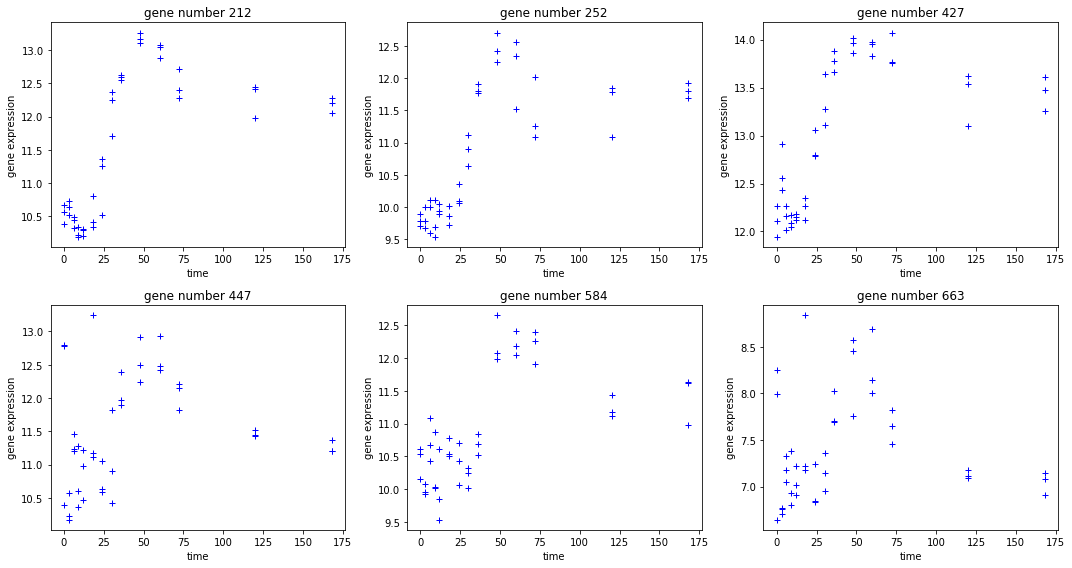

In [6]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

gene_indx = np.sort(np.random.choice(n_train, 6))

for i in range(6):
    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    this_plot.plot(timepoints, y_train[n, :].T, '+', color = 'blue');
    this_plot.set_ylabel('gene expression')
    this_plot.set_xlabel('time')
    this_plot.set_title('gene number {}'.format(n))
    
f.tight_layout()

### Define regressors

We model the time course using cubic B-splines. Let $\alpha$ be the degrees of freedom of the B-splines, and this is the parameter we seek to choose using cross-validation. 

For a given degrees of freedom, the B-spline basis is given by an $n_{t}\times n_{x}$
matrix $X_{df}$, where the each column of $X_{df}$ is a B-spline
basis vector evaluated at the $n_{t}$ timepoints.  Note that $n_{x}$
increases with increasing degrees of freedom. 

Note that we only use B-splines to smooth the first 11 timepoints. For the last three timepoints, $t = 72, 120, 168$, we use indicator functions on each timepoint as three extra basis vectors.  In other words, we append to the regressor matrix three columns, where each column is 1 if $t = 72, 120$, or $168$, respectively, and 0 otherwise.  We do this to avoid numerical issues in the matrix $X^T X$. Because the later timepoints are more spread out, the B-spline basis are close to zero at the later timepoints, leading to matrices close to being singular. 


In [7]:
# Simulate passing arguments in on the command line so that the notebook
# looks more like those in ``cluster_scripts``.
class Args():
    def __init__(self):
        pass
    
args = Args()
args.df = 7
args.degree = 3
args.num_components = 10

In [8]:
regressors = spline_bases_lib.get_genomics_spline_basis(
    timepoints, df=args.df, degree=3)

regs = reg_lib.Regressions(y_train, regressors)

We plot the B-spline matrix for several degrees of freedom below: 

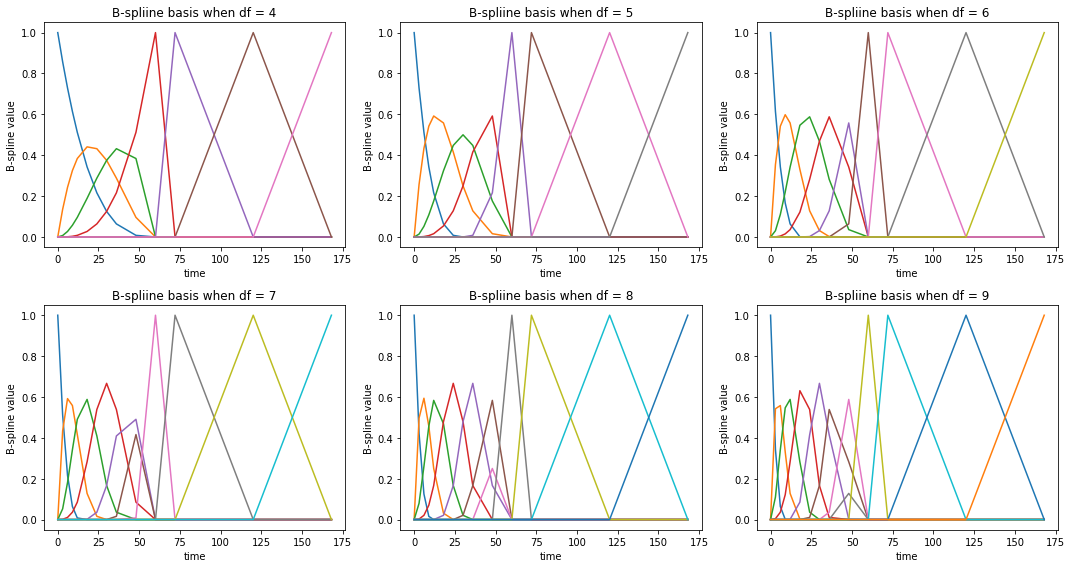

In [9]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

i = 0
for df in [4, 5, 6, 7, 8, 9]: 
    _regressors = spline_bases_lib.get_genomics_spline_basis(
            timepoints, exclude_num=3, df=df)
    
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    this_plot.plot(timepoints, _regressors); 
    this_plot.set_xlabel('time')
    this_plot.set_ylabel('B-spline value')
    this_plot.set_title('B-spliine basis when df = {}'.format(df))
    
    i += 1
    
f.tight_layout()

We display the regressor matrix below. 

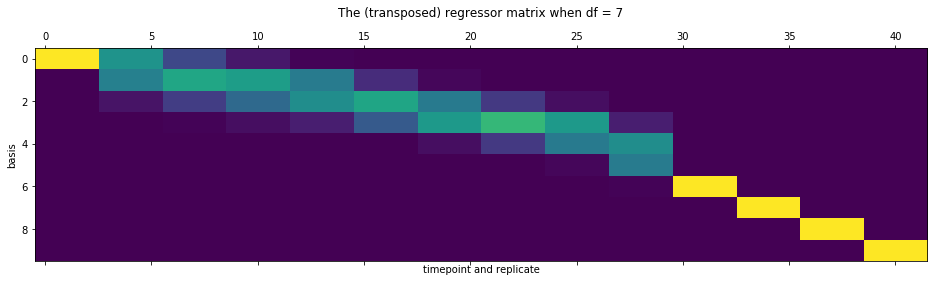

In [10]:
plt.matshow(regs.x.T)
plt.ylabel('basis')
plt.xlabel('timepoint and replicate')
plt.title('The (transposed) regressor matrix when df = {}\n'.format(args.df));

With the regressor $X$ defined above, for each gene $g$
we model $P\left(y_{g}\vert\beta_{g},\sigma_{g}^{2}\right) = \mathcal{N}\left(y_{g}\vert X\beta_{g},\sigma_{g}^{2}\right)$.  In the second stage, we will want to cluster $\beta_{g}$ taking into account its uncertainty on each gene.  To do this, we wish to estimate the posterior mean $\mathbb{E}[\beta_g | y_g]$ and covariance $\mathrm{Cov}(\beta_{g} | y_g)$ with flat priors for both $\beta_g$ and $\sigma^2_g$. 

For each gene, we estimate the posterior with a mean field variational Bayes (MFVB) approximation
$q\left(\sigma_{g}^{2},\beta_{g};\hat{\eta}_{g}\right)$ to the posterior
$P\left(\beta_{g},\sigma_{g}^{2}\vert y_{g}\right)$. 

In particular, we take $q\left(\sigma_{g}^{2},\beta_{g};\hat{\eta}_{g}\right) = q^*\left(\sigma_{g}^{2}\right)q^*\left(\beta_{g}\right)$, where 
$q^*\left(\sigma_{g}^{2}\right)$ is a dirac delta function, and we optimize over its a location parameter; $q^*\left(\beta_{g}\right)$ is a Gaussian density and we optimize over its mean and covariance. 

The optimal variational approximation has a closed form that is formally identical to the standard frequentist
mean and covariance estimate for linear regression.  Explicitly, the optimal variational distribution is, 

\begin{align*}
q^*(\beta_g) &= \mathcal{N}\Big(\beta_g \; \Big| \; (X^TX)^{-1}X^T y_g, \; \hat\tau_g(X^TX)^{-1}\Big)\\
q^*(\sigma^2_g) &= \delta\{\sigma^2_g = \hat\tau_g\}
\end{align*}

where $\hat\tau_g = \frac{1}{n_t - n_x}\|y_g -X(X^TX)^{-1}X^T y_g\|_2^2$. 



The advantage of the MVFB construction is that $\hat{\eta}_{g}$
for $g=1,...,n_{g}$ satisfies set of $n_{g}$ independent M-estimation objectives, allowing us to apply our infinitesimal jackknife results.
Specifically, defining $\theta_{reg}:=\left(\eta_{1},...,\eta_{n_{g}}\right)$,
we wish to minimize
\begin{align*}
F_{reg}\left(\theta_{reg},\alpha\right) & =\sum_{g=1}^{n_{g}}KL\left(q\left(\sigma_{g}^{2},\beta_{g};\eta_{g}\right)||P\left(\beta_{g},\sigma_{g}^{2}\vert y_{g}\right)\right)\\
 & =-\sum_{g=1}^{n_{g}}\mathbb{E}_{q}\left[\log P\left(\beta_{g},\sigma_{g}^{2}\vert y_{g}\right)\right]+\mathbb{E}_{q}\left[\log q\left(\beta_{g},\sigma_{g}^{2}\vert\eta_{g}\right)\right]\\
 & :=\sum_{g=1}^{n_{g}}F_{reg,g}\left(\eta_{g},\alpha\right).
\end{align*}
Our M-estimator, then, is
\begin{align*}
\frac{\partial F_{reg}\left(\theta_{reg},\alpha\right)}{\partial\theta_{reg}} & =0.
\end{align*}

The class $\texttt{regs}$ can calculate the optimal variational parameters for each gene.  In particular, the variational parameters $\eta_g$  consist of a variational mean and covariance for $\beta_g$, as well as a location estimate for $\sigma^2_g$.  

In [11]:
reg_time = time.time()
opt_reg_params = regs.get_optimal_regression_params()
reg_time = time.time() - reg_time
print('Regression time: {} seconds'.format(reg_time))

Regression time: 0.02948451042175293 seconds


Here are what some of the fits look like. Each regression produces a prediction $\hat{y}_{g}:=X\mathbb{E}_{q}\left[\beta_g\right]$, plotted with the heavy red line above. The light red are predictions when $\beta_g$ is drawn from $q^*(\beta_g)$; the spread of the light red is intended to give a sense of the covariance of $\beta_g$. 

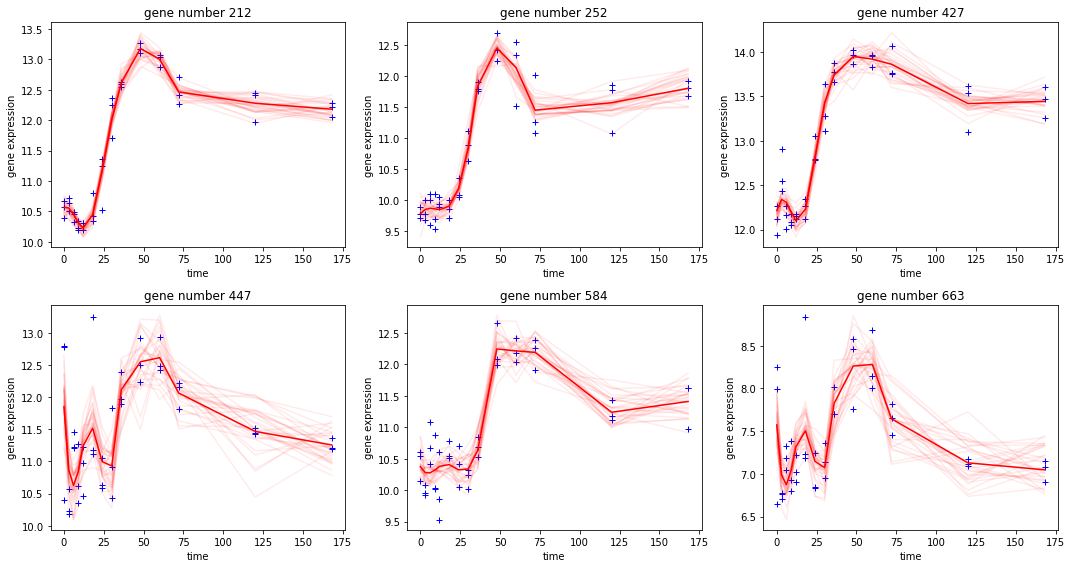

In [12]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

for i in range(6):
    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    plot_utils_lib.PlotRegressionLine(
        timepoints, regs, opt_reg_params, n, this_plot=this_plot)
    
f.tight_layout()

We also define and save data for the test regressions, which we will use later to evaluate out-of-sample performance.  The training regressions will be saved below with the rest of the fit.


In [13]:
regs_test = reg_lib.Regressions(y_test, regressors)
test_regression_outfile = '../fits/test_regressions.json'
with open(test_regression_outfile, 'w') as outfile:
    outfile.write(regs_test.to_json())

## The second stage: fit a mixture model.

### Transform the parameters before clustering

We are interested in the pattern of gene expression, not the absolute
level, so we wish to cluster $\hat{y}_{g}-\bar{\hat{y}}_{g}$, where
$\bar{\hat{y}}_{g}$ is the average over time points. Noting that
the $n_{t}\times n_{t}$ matrix $\text{Cov}_{q}\left(\hat{y}_{g}-\bar{\hat{y}}_{g}\right)$
is rank-deficient because we have subtracted the mean, the final step
is to rotate $\hat{y}_{g}-\bar{\hat{y}}_{g}$ into a basis where the
zero eigenvector is a principle axis and then drop that component.

Call these transformed regression coefficients $\gamma_{g}$ and observe that
$\text{Cov}_{q}\left(\gamma_{g}\right)$ has a closed form and is full-rank. It is these $\gamma_{g}$s that we will cluster in the second stage. 

We briefly note that the re-centering operation could have been equivalently achieved by making a constant one of the regressors.  We chose this implementation because it also allows the user to cluster more complex, non-linear transformations of the regression coefficients, though we leave this extension for future work.

We note that the transformations described in this section are done automatically in the ``GMM`` class.  We are only calculating these transformations here for exposition.

In [14]:
# Get the matrix that does the transformation.
transform_mat, unrotate_transform_mat = \
    trans_reg_lib.get_reversible_predict_and_demean_matrix(regs.x)
trans_obs_dim = transform_mat.shape[0]

If $T$ is the matrix that effects the transformation, then 

\begin{align*}
    \mathbb{E}_q[\gamma_g] &= T \mathbb{E}_q[\beta_g]\\
    \text{Cov}_q(\gamma_q) &= T \text{Cov}_q(\beta_g) T^T
\end{align*}

The transformed parameters are also regression parameters, just in a different space.

In [15]:
# Apply the transformation
transformed_reg_params = \
    trans_reg_lib.multiply_regression_by_matrix(
        opt_reg_params, transform_mat)

We now visualize the transformed coefficients and their uncertainty.

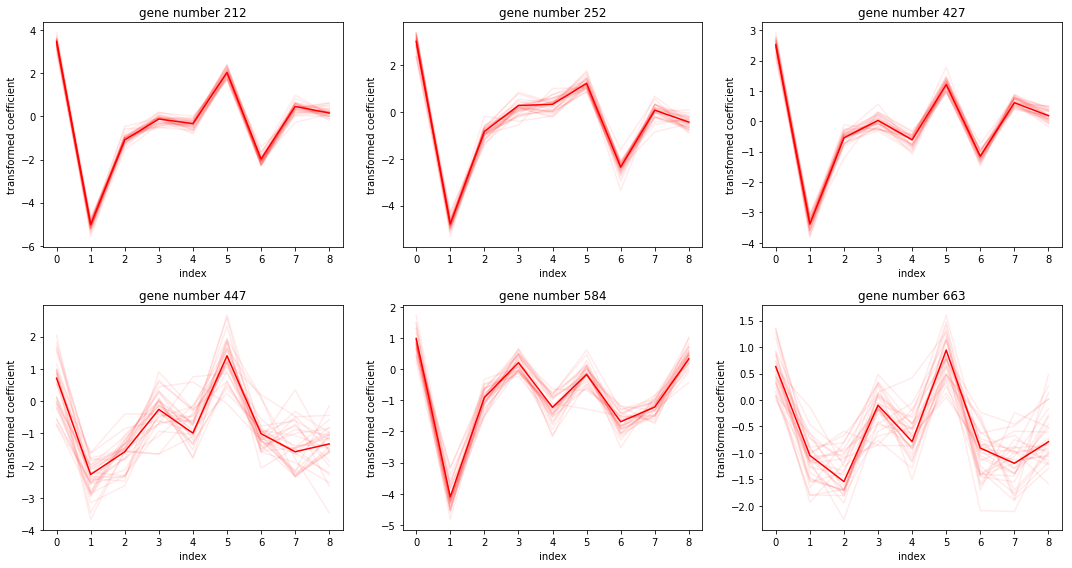

In [16]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

transformed_beta = transformed_reg_params['beta_mean']
transformed_beta_info = transformed_reg_params['beta_info']

for i in range(6):
    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3] 
    this_plot.plot(transformed_beta[n, :], color = 'red');
    this_plot.set_ylabel('transformed coefficient')
    this_plot.set_xlabel('index')
    this_plot.set_title('gene number {}'.format(n))

    # draw from the variational distribution, to plot uncertainties
    for j in range(30): 
        transformed_beta_draw = np.random.multivariate_normal(
            transformed_beta[n, :], \
             np.linalg.inv(transformed_beta_info[n]))

        axarr[int(np.floor(i / 3)), i % 3].plot(transformed_beta_draw, 
                                                color = 'red', alpha = 0.08);

f.tight_layout()

The heavy red lines are the means of the transformed regression coefficients; shaded lines are draws from the variational distribution. 

It is these transformed coefficients, $\gamma_g$, that we cluster in the second stage. 

### Estimate an optimal clustering.

We now define a clustering problem for the $\gamma_{g}$. Let $n_{k}$
be the number of clusters, and $\mu_{1},...,\mu_{n_{k}}$ be the
cluster centers. Also let $z_{gk}$be the binary indicator for the
$g$th gene belonging to cluster $k$. We then define the following
generative model
\begin{align*}
\\
P\left(\pi\right) & =Dirichlet\left(\omega\right)\\
P\left(\mu_{k}\right) & =\mathcal{N}\left(\mu_{k}\vert0,\Sigma_{0}\right) \quad \text{for } \quad k = 1, ..., n_k\\
P\left(z_{gk}=1\vert\pi_{k}\right) & =\pi_{k} \quad \text{for } \quad k = 1, ..., n_k; \; n = 1, ..., n_g\\
P\left(\gamma_{g}\vert z_{gk}=1,\mu_{k},\eta_{g}\right) & =\mathcal{N}\left(\gamma_{g}\vert\mu_{k},\text{Cov}_{q}\left(\gamma_{g}\right)+\epsilon I_{n_{t}-1}\right)
\quad \text{for } \quad k = 1, ..., n_k; \; n = 1, ..., n_g.
\end{align*}

where $\epsilon$ is a small regularization parameter, which helped our optimization produce more stable results. 

We will estimate the clustering using the maximum
a posteriori (MAP) estimator of $\theta_{clust}:=\left(\mu,\pi\right)$.
This defines an optimization objective that we seek to minimize: 
\begin{align*}
F_{clust}\left(\theta_{clust},\theta_{reg}\right) & = - \sum_{g=1}^{n_{g}}E_{q^*_{z}}\Big\{\log P\left(\gamma_{g}\vert\eta_{g},\mu,\pi, z_g \right)-\log P(z_g | \pi)\Big\} - \log P\left(\mu\right)-\log P\left(\pi\right)
\end{align*}
which, for every value of $\theta_{reg}$, we expect to satisfy
\begin{align*}
\frac{\partial F_{clust}\left(\theta_{clust},\theta_{reg}\right)}{\partial\theta_{clust}} & =0.
\end{align*}

Note that $\theta_{clust}$ involves only the ''global'' parameters $\mu$ and $\pi$. We did take a variational distribution for the $z_{gk}$s, represented by independent Bernoulli distribution, but the optimal $q^*_z$ can be written as a function of $\mu$ and $\pi$. Hence, our optimization objective only involves these global parameters. 


In [17]:
# Define prior parameters.
num_components = args.num_components
epsilon = 0.1
loc_prior_info_scalar = 1e-5

trans_obs_dim = regs.x.shape[1] - 1
prior_params = \
    rm_lib.get_base_prior_params(trans_obs_dim, num_components)
prior_params['probs_alpha'][:] = 1
prior_params['centroid_prior_info'] = loc_prior_info_scalar * np.eye(trans_obs_dim)

In [18]:
gmm = rm_lib.GMM(args.num_components,
                 prior_params, regs, opt_reg_params,
                 inflate_coef_cov=None,
                 cov_regularization=epsilon)

In our experiment, the number of clusters $n_k$ was chosen to be {{args.num_components}}. 
We set $\omega$ to be the ones vector of length $n_{k}$.  The prior info for the cluster centers $\Sigma_{0}$ is {{loc_prior_info_scalar}}$\times I$. $\epsilon$ was set to be {{epsilon}}.

Let us examine the optimization objective.  First, we'll inspect the likelihood terms. What follows is the likelihood given that gene $g$ belongs to cluster $k$.

In [19]:
print(inspect.getsource(rm_lib.get_log_lik_nk))

def get_log_lik_nk(centroids, probs, x, x_infos):
    loc_log_lik = \
        -0.5 * (-2 * np.einsum('ni,kj,nij->nk', x, centroids, x_infos) +
                np.einsum('ki,kj,nij->nk', centroids, centroids, x_infos))

    log_probs = np.log(probs[0, :])
    log_lik_by_nk = loc_log_lik + log_probs.T

    return log_lik_by_nk



We can then optimize for $q^*_z$, which can be parametrized by its mean $\mathbb{E}_{q^*_z}[z]$.  We note that this update has a closed form given $\theta_{clust}$, so there is no need to solve an optimization problem to find $q^*_z(z)$.  We additionally note that we do not use the EM algorithm, which we found to have exhibit extremely poor convergence rates.  Rather, we set $q^*_z(z)$ to its optimal value given $\theta_{clust}$ and return the objective as a function of $\theta_{clust}$ alone, allowing the use of more general and higher-quality optimization routines.

In [20]:
print(inspect.getsource(rm_lib.get_e_z))

def get_e_z(log_lik_by_nk):
    log_const = paragami.simplex_patterns.logsumexp(log_lik_by_nk, axis=1)
    e_z = np.exp(log_lik_by_nk - log_const)
    return e_z



With the optimal parameters for $z_{nk}$, we combine the likelihood term with the prior and entropy terms. 

In [21]:
print(inspect.getsource(rm_lib.wrap_get_loglik_terms))
print(inspect.getsource(rm_lib.wrap_get_kl))

def wrap_get_loglik_terms(gmm_params, transformed_reg_params):
    log_lik_by_nk = get_log_lik_nk(
        centroids=gmm_params['centroids'],
        probs=gmm_params['probs'],
        x=transformed_reg_params['beta_mean'],
        x_infos=transformed_reg_params['beta_info'])

    e_z = get_e_z(log_lik_by_nk)

    return log_lik_by_nk, e_z

def wrap_get_kl(gmm_params, transformed_reg_params, prior_params):
    log_lik_by_nk, e_z = \
        wrap_get_loglik_terms(gmm_params, transformed_reg_params)
    log_prior = get_log_prior(
        gmm_params['centroids'], gmm_params['probs'], prior_params)
    return get_kl(log_lik_by_nk, e_z, log_prior)



This objective function is wrapped in the ``GMM`` class method ``get_params_kl``.

In [22]:
print(inspect.getsource(gmm.get_params_kl))

    def get_params_kl(self, gmm_params):
        """Get the optimization objective as a function of the mixture
        parameters.
        """
        return wrap_get_kl(
            gmm_params, self.transformed_reg_params, self.prior_params)



### Optimization

For optimization we make extensive use of the [autograd](https://github.com/HIPS/autograd) library for automatic differentiation and the [paragami](https://github.com/rgiordan/paragami) library for parameter packing and sparse Hessians.   These packages' details are beyond the scope of the current notebook.

First, we do a k-means initialization.

In [23]:
print('Running k-means init.')
init_gmm_params = \
    rm_lib.kmeans_init(gmm.transformed_reg_params,
                       gmm.num_components, 50)
print('Done.')
init_x = gmm.gmm_params_pattern.flatten(init_gmm_params, free=True)

Running k-means init.
Done.


 We note that
the match between "exact" cross-validation (removing time points and
re-optimizing) and the IJ was considerably improved by
using a high-quality second-order optimization method.  In particular, for these
experiments, we employed the Newton conjugate-gradient trust region method
(Chapter 7.1 of Wright et al [1999]) as implemented by the method
``trust-ncg`` in ``scipy.optimize``, preconditioned by the Cholesky
decomposition of an inverse Hessian calculated at an initial approximate
optimum.

 We found that first-order or quasi-Newton
methods (such as BFGS) often got stuck or terminated at points with fairly large
gradients. At such points our method does not apply in theory nor, we found,
very well in practice.

The inverse Hessian used for the preconditioner was with respect to
the clustering parameters only and so could be calculated quickly, in contrast
to the $H_1$ matrix used for the IJ, which includes the
regression parameters as well. 

First, run with a low tolerance to get a point at which to evaluate an initial preconditioner.

In [24]:
gmm.conditioned_obj.reset() # Reset the logging and iteration count.
gmm.conditioned_obj.set_print_every(1)

opt_time = time.time()
gmm_opt, init_x2 = gmm.optimize(init_x, gtol=1e-2)
opt_time = time.time() - opt_time

Iter 0: f = -159.11834165
Iter 1: f = -159.67926278
Iter 2: f = -159.97782885
Iter 3: f = -160.15878320
Iter 4: f = -159.59447036
Iter 5: f = -160.19209687
Iter 6: f = -160.27259154
Iter 7: f = -160.29486553
Iter 8: f = -160.33460656
Iter 9: f = -160.34154288
Iter 10: f = -160.32382096
Iter 11: f = -160.34447865
Iter 12: f = -160.34634639
Iter 13: f = -160.34692896


Next, set the preconditioner using the square root inverse Hessian at the point ``init_x2``.

In [25]:
tic = time.time()
h_cond = gmm.update_preconditioner(init_x2)
opt_time += time.time() - tic

The method ``optimize_fully`` repeats this process of optimizing and re-calculating the preconditioner until the optimal point does not change.

In [26]:
gmm.conditioned_obj.reset()
tic = time.time()
gmm_opt, gmm_opt_x = gmm.optimize_fully(
    init_x2, verbose=True)
opt_time += time.time() - tic
print('Optimization time: {} seconds'.format(opt_time))

Preconditioned iteration 1
  Running preconditioned optimization.
Iter 0: f = -160.34692896
Iter 1: f = -160.34694250
Iter 2: f = -160.34694250
Preconditioned iteration 2
  Getting Hessian and preconditioner.
  Running preconditioned optimization.
Iter 3: f = -160.34694250
Iter 4: f = -160.34694250
Converged.
Optimization time: 14.977992534637451 seconds


``paragami`` patterns allow conversion between unconstrained vectors and dictionaries of parameter values.  After "folding" the optimal ``gmm_opt_x``, ``opt_gmm_params`` contains a dictionary of optimal cluster centroids and cluster probabilities.

In [27]:
opt_gmm_params = gmm.gmm_params_pattern.fold(gmm_opt_x, free=True)
print(opt_gmm_params.keys())
print(np.sort(opt_gmm_params['probs']))

odict_keys(['centroids', 'probs'])
[[0.01567608 0.04016882 0.06955236 0.07427946 0.09373695 0.0947442
  0.09653288 0.12626624 0.15739176 0.23165127]]


Each gene's regression line has an inferred cluster membership given by $\mathbb{E}_{q^*_z}[z_g]$, and an expected posterior centroid given by $\sum_k \mathbb{E}_{q^*_z}[z_{gk}] \mu_k$.  This expected posterior centroid can be un-transformed to give a prediction for the observation.

It is the difference between this prediction line --- which is a function of the clustering --- and the actual data that we consider to be the "error" of the model. 

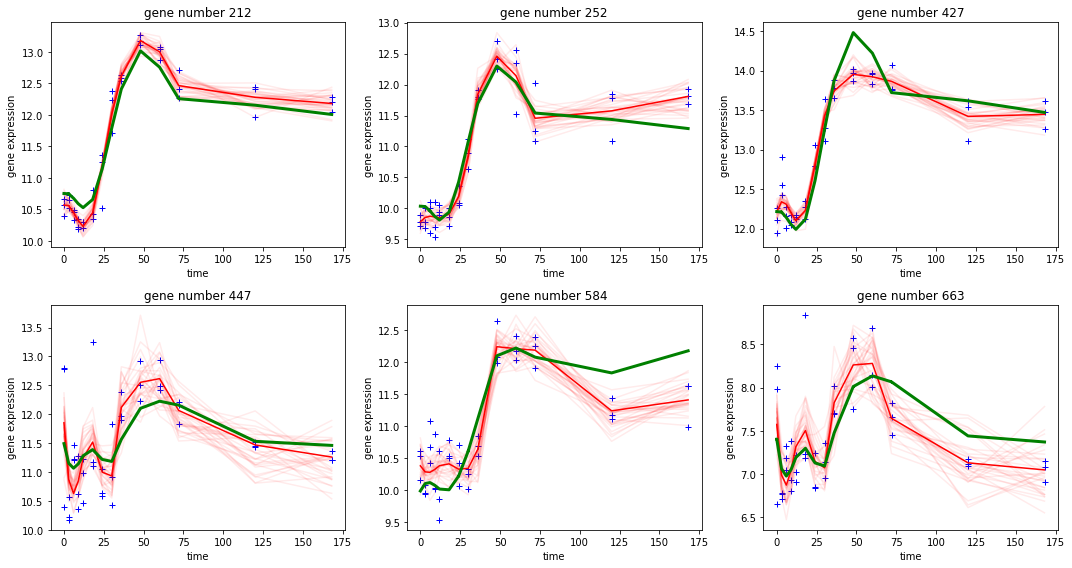

In [28]:
gmm_pred = mse_utils.get_predictions(gmm, opt_gmm_params, opt_reg_params)

f, axarr = plt.subplots(2, 3, figsize=(15,8))

for i in range(6):
    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    plot_utils_lib.PlotRegressionLine(
        timepoints, regs, opt_reg_params, n, this_plot=this_plot)
    plot_utils_lib.PlotPredictionLine(
        timepoints, regs, gmm_pred, n, this_plot=this_plot)
    
f.tight_layout()


### Calculating $H_1$ for the IJ

We seek to choose the degrees of freedom $\alpha$ for the B-splines using cross-validation. We leave out one or more timepoints, and fit using only the remaining timepoints. We then estimate the test error by predicting the value of the genes at the held out timepoints. 

To do this, we define time weights $w_{t}$ by observing that, for each $g$,
the term $\mathbb{E}_{q}\left[\log P\left(\beta_{g},\sigma_{g}^{2}\vert y_{g}\right)\right]$
decomposes into a sum over time points:
\begin{align*}
F_{reg,g}\left(\eta_{g},\alpha,w\right) & :=-\sum_{t=1}^{n_{t}}w_{t}\left(-\frac{1}{2}\sigma_{g}^{-2}\left(y_{g,t}-\left(X\beta_{g}\right)_{t}\right)^{2}-\frac{1}{2}\log\sigma_{g}^{2}\right)+\mathbb{E}_{q}\left[\log q\left(\beta_{g},\sigma_{g}^{2}\vert\eta_{g}\right)\right].
\end{align*}
We naturally define $F_{reg}\left(\theta_{reg},\alpha,w\right):=\sum_{g=1}^{n_{g}}F_{reg,g}\left(\eta_{g},\alpha,w\right).$


By defining $\theta=\left(\theta_{clust},\theta_{reg}\right)$, we
then have an M-estimator
\begin{align*}
G\left(\theta,w,\alpha\right) & :=\left(\begin{array}{c}
\frac{\partial F_{reg}\left(\theta_{reg},w,\alpha\right)}{\partial\theta_{reg}}\\
\frac{\partial F_{clust}\left(\theta_{clust},\theta_{reg}\right)}{\partial\theta_{clust}}
\end{array}\right)=0.
\end{align*}

We can then apply the IJ to approximate the leaving out of various timepoints. 

Note that what we call the "Hessian" for this two-step procedure is not really a Hessian, as it is not symmetric. More precisely, it is the Jacobian of $G$, or what we defined as $H_1$ in the text. 

Calculating $H_1$ is the most time-consuming part of the infinitesimal jackknife, since the $H_1$ matrix is quite large (though sparse).  However, once $H_1$ is computed, calculating each $\theta_{IJ}(w)$ is extremely fast.

$H_1$ can be computed in blocks: 
\begin{align*}
H_1 = \begin{pmatrix} 
\nabla^2_{\theta_{reg}} F_{reg} & 0 \\  \nabla_{\theta_{reg}} \nabla_{\theta_{clust}} F_{clust} & \nabla^2_{\theta_{clust}} F_{clust} \end{pmatrix}
\end{align*}

The code refers to $\nabla^2_{\theta_{clust}} F_{clust}$ as the "GMM Hessian".  It refers to $\nabla_{\theta_{reg}} \nabla_{\theta_{clust}} F_{clust}$ as the "cross Hessian".  And it refers to $\nabla^2_{\theta_{reg}} F_{reg}$ as the "regression Hessian", which itself is block diagonal, with each block an observation.  Due to details of the implementation of block sparse Hessians using forward mode automatic differnetiation in the class ``vittles.SparseBlockHessian``, the code below confusingly refers to each regression parameter as a "block".

When the ``FitDerivatives`` class is initialized, it calculates these blocks separately and stacks them into the attribute ``full_hess``, which is a sparse matrix representing $H_1$.

In [29]:
# Even though $H_1$ is not a Hessian, by force of habit we call the time to
# compute it ``hess_time``.
hess_time = time.time()
fit_derivs = sens_lib.FitDerivatives(
    opt_gmm_params, opt_reg_params,
    gmm.gmm_params_pattern, regs.reg_params_pattern,
    gmm=gmm, regs=regs,
    print_every=10)
hess_time = time.time() - hess_time
print('Total hessian time: {} seconds'.format(hess_time))

Initializing FitDerivatives.
Getting t Jacobian.
Getting full Hessian.
   Getting GMM Hessian...
   GMM Hessian time: 2.349353075027466
   Getting cross Hessian...
   Cross Hessian time: 35.75162696838379
   Getting regression Hessian...
Block index 0 of 66.
Block index 10 of 66.
Block index 20 of 66.
Block index 30 of 66.
Block index 40 of 66.
Block index 50 of 66.
Block index 60 of 66.
Done differentiating.
   Regression Hessian time: 125.55598878860474
Done with full Hessian.
Total hessian time: 176.30212998390198 seconds


### Save results as a compressed file. 

The results, including $H_1$, are now saved.  To calculate the exact CV, these results (including the preconditioner) will be loaded and the model will be refit with timepoints left out.  To calculate the IJ, the same results will be loaded and $H_1$ will be used to calculate the IJ.

In [30]:
extra_metadata = dict()
extra_metadata['opt_time'] = opt_time
extra_metadata['reg_time'] = reg_time
extra_metadata['hess_time'] = hess_time
extra_metadata['df'] = args.df
extra_metadata['degree'] = args.degree

npz_outfile = '../fits/initial_fit.npz'
saving_gmm_utils.save_initial_optimum(
    npz_outfile,
    gmm=gmm,
    regs=regs,
    timepoints=timepoints,
    fit_derivs=fit_derivs,
    extra_metadata=extra_metadata)

### Bibliography

J. E. Shoemaker, S. Fukuyama, A. J. Eisfeld, D. Zhao, E. Kawakami, S. Sakabe, T. Maemura,
T. Gorai, H. Katsura, Y. Muramoto, S. Watanabe, T. Watanabe, K. Fuji, Y. Matsuoka, H. Kitano,
and Y. Kawaoka. An Ultrasensitive Mechanism Regulates Influenza Virus-Induced Inflammation.
PLoS Pathogens, 11(6):1–25, 2015

S. Wright and J. Nocedal. Numerical optimization. Springer Science, 35(67-68):7, 1999.